<a href="https://colab.research.google.com/github/Bimalv01/Natural-Language-Process/blob/main/LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim import corpora
from gensim.models import LdaModel, Word2Vec

In [9]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Data Collection
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
documents = newsgroups.data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
# Text Preprocessing
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

preprocessed_documents = [preprocess_text(doc) for doc in documents]


In [11]:
# Topic Modeling with LDA
dictionary = corpora.Dictionary(preprocessed_documents)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=10000)
corpus = [dictionary.doc2bow(doc) for doc in preprocessed_documents]
lda_model = LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)

# Display LDA topics
topics = lda_model.print_topics(num_words=10)
print("LDA Topics:")
for topic in topics:
    print(topic)

LDA Topics:
(0, '0.029*"game" + 0.019*"team" + 0.012*"player" + 0.011*"year" + 0.009*"play" + 0.009*"season" + 0.008*"hockey" + 0.007*"win" + 0.007*"league" + 0.006*"st"')
(1, '0.034*"x" + 0.019*"file" + 0.013*"image" + 0.012*"window" + 0.009*"program" + 0.009*"edu" + 0.008*"c" + 0.007*"ftp" + 0.007*"use" + 0.007*"version"')
(2, '0.019*"god" + 0.010*"one" + 0.008*"people" + 0.007*"would" + 0.007*"christian" + 0.007*"say" + 0.005*"jesus" + 0.005*"believe" + 0.005*"word" + 0.005*"church"')
(3, '0.015*"car" + 0.007*"one" + 0.007*"bike" + 0.006*"power" + 0.005*"new" + 0.005*"like" + 0.005*"used" + 0.005*"also" + 0.005*"good" + 0.005*"get"')
(4, '0.010*"space" + 0.006*"system" + 0.006*"research" + 0.005*"program" + 0.005*"year" + 0.005*"data" + 0.005*"also" + 0.005*"use" + 0.005*"nasa" + 0.004*"information"')
(5, '0.014*"drive" + 0.011*"card" + 0.011*"do" + 0.009*"would" + 0.009*"disk" + 0.009*"system" + 0.009*"thanks" + 0.008*"know" + 0.008*"anyone" + 0.008*"problem"')
(6, '0.218*"ax" + 0.

In [12]:
# Word Embeddings
word2vec_model = Word2Vec(sentences=preprocessed_documents, vector_size=100, window=5, min_count=5, workers=4)


In [13]:
# Generate document vectors
def document_vector(doc):
    doc = [word for word in doc if word in word2vec_model.wv.index_to_key]
    if len(doc) > 0:
        return np.mean(word2vec_model.wv[doc], axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

document_vectors = []
for doc in preprocessed_documents:
    vec = document_vector(doc)
    if np.any(vec):
        document_vectors.append(vec)

if document_vectors:
    document_vectors = np.array(document_vectors)
else:
    raise ValueError("No valid document vectors found.")

In [15]:
from gensim.matutils import corpus2dense
# Document Similarity
lda_vectors = [lda_model.get_document_topics(bow) for bow in corpus]
lda_vectors = corpus2dense(lda_vectors, num_terms=lda_model.num_topics).T

lda_similarity = cosine_similarity(lda_vectors)
word2vec_similarity = cosine_similarity(document_vectors)

In [16]:
# Clustering
kmeans_lda = KMeans(n_clusters=10, random_state=42).fit(lda_vectors)
kmeans_word2vec = KMeans(n_clusters=10, random_state=42).fit(document_vectors)

# PCA for visualization
pca_lda = PCA(n_components=2).fit_transform(lda_vectors)
pca_word2vec = PCA(n_components=2).fit_transform(document_vectors)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


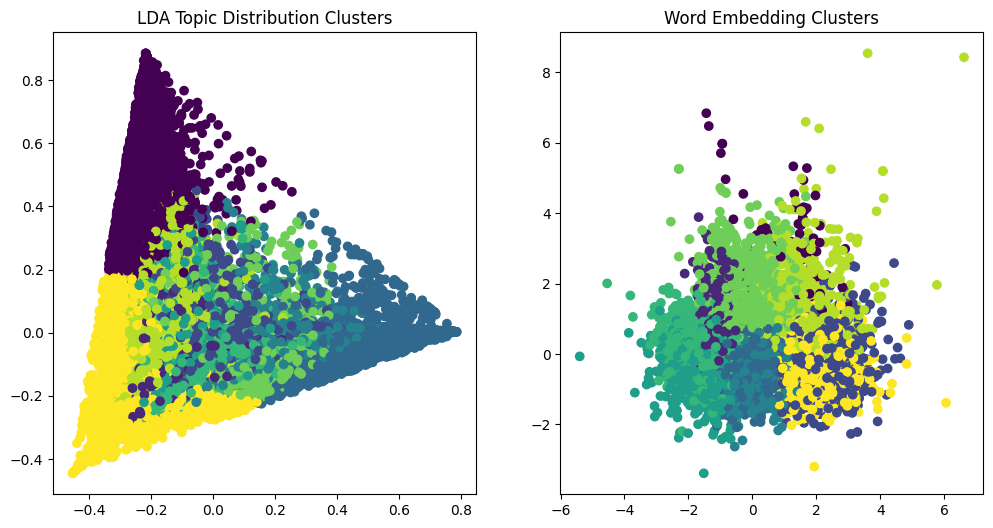

In [17]:
# Visualization
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(pca_lda[:, 0], pca_lda[:, 1], c=kmeans_lda.labels_, cmap='viridis')
plt.title('LDA Topic Distribution Clusters')

plt.subplot(1, 2, 2)
plt.scatter(pca_word2vec[:, 0], pca_word2vec[:, 1], c=kmeans_word2vec.labels_, cmap='viridis')
plt.title('Word Embedding Clusters')

plt.show()